In [13]:
import numpy as np
import pandas as pd
from utils import  amplitude_scaling, load_dataset, save_distance_matrix
from sklearn.neighbors import KNeighborsClassifier
from dtaidistance import dtw
from sklearn.metrics import classification_report 
from sklearn.model_selection import GridSearchCV, cross_val_predict
from utils import dtw_dist, decode_y, top_flop_f1
from pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    make_scorer
)
from scikitplot.metrics import plot_roc
from scikitplot.metrics import plot_precision_recall
import matplotlib.pyplot as plt
from sktime.transformations.series.summarize import SummaryTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier

In [16]:
X_train_raw, y_train_raw, X_test_raw, y_test_raw,enc_dict = load_dataset('../dataset_ts/ts_data_raw.npz', squeeze=False)

In [7]:
X_train_raw.shape

(7500, 1, 1280)

In [51]:
summary = SummaryTransformer(summary_function=('mean', 'min', 'max', 'median', 'sum', 'skew', 'kurt', 'var', 'std', 'mad', 'sem', 'nunique', 'count'))
X_test_summary = summary.fit_transform(X_test_raw)
summary.reset()
X_train_summary = summary.fit_transform(X_train_raw)


In [18]:
X_train_summary.shape

(7500, 18)

In [52]:
scaler = MinMaxScaler()
X_train_summary_scaled = scaler.fit_transform(X_train_summary)
X_test_summary_scaled = scaler.transform(X_test_summary)

KNN

In [20]:
# knn
parameters = {'n_neighbors': [1,5,10,15,20,30,40,50,60,80,100,125,150,200],
              'weights': ['distance', 'uniform'],
              'metric': ['euclidean', 'cosine', 'cityblock'],
              'n_jobs': [-1]
              }
knn = KNeighborsClassifier()
clf = GridSearchCV(
    knn, 
    parameters, 
    scoring='accuracy', 
    n_jobs=-1,
    refit=True,
    )
clf.fit(X_train_summary_scaled, y_train_raw)
print(clf.best_estimator_)
print(clf.best_params_)
print(clf.best_score_)

KNeighborsClassifier(metric='cosine', n_jobs=-1, n_neighbors=100,
                     weights='distance')
{'metric': 'cosine', 'n_jobs': -1, 'n_neighbors': 100, 'weights': 'distance'}
0.34040000000000004


                   precision    recall  f1-score   support

              emo       0.26      0.17      0.21       375
             folk       0.16      0.06      0.09       375
             goth       0.12      0.04      0.06       375
            happy       0.39      0.46      0.42       375
      heavy-metal       0.30      0.45      0.36       375
       honky-tonk       0.29      0.47      0.36       375
           j-idol       0.34      0.43      0.38       375
             kids       0.34      0.32      0.33       375
   minimal-techno       0.50      0.53      0.51       375
              mpb       0.18      0.09      0.12       375
          new-age       0.45      0.53      0.48       375
            opera       0.30      0.23      0.26       375
            piano       0.60      0.49      0.54       375
progressive-house       0.32      0.16      0.22       375
            salsa       0.29      0.58      0.39       375
        sertanejo       0.30      0.60      0.40       

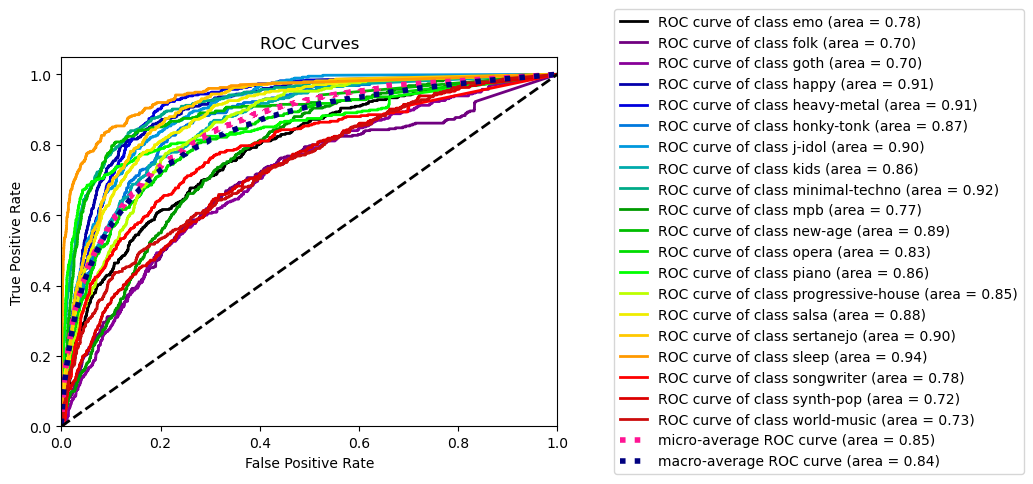

TOP 5 F1-SCORE:
sleep: 0.656298600311042
piano: 0.5398230088495575
minimal-techno: 0.5148005148005148
new-age: 0.48284313725490197
happy: 0.4236453201970443


FLOP 5 F1-SCORE:
goth: 0.056451612903225805
folk: 0.08829174664107485
mpb: 0.1195079086115993
synth-pop: 0.16140350877192983
emo: 0.20745542949756887


In [22]:
# knn selected model
model = KNeighborsClassifier(metric='cosine', n_jobs=-1, n_neighbors=100, weights='distance')
y_pred = decode_y(cross_val_predict(model, X_train_summary_scaled, y_train_raw, cv=10), enc_dict)
y_pred_proba = cross_val_predict(model, X_train_summary_scaled, y_train_raw, cv=10, method='predict_proba')

print(classification_report(decode_y(y_train_raw, enc_dict), y_pred))
plot_roc(decode_y(y_train_raw, enc_dict), y_pred_proba)
plt.legend(loc='center left',prop={'size': 10}, bbox_to_anchor=(1.1, 0.5))
plt.show()

top_flop_f1(decode_y(y_train_raw, enc_dict), y_pred)

Decision Tree

In [21]:
# decision tree
parameters = {'criterion': ['entropy'],
              'min_samples_split': [2,4,6,8,10,14,18,24,30,40,50,60,75,100],
              'min_samples_leaf': [1,2,4,6,8,10,14,18,24,30,40,50,60,75,100],
              'max_depth': [4,6,8,10,12,14,16,20,24]
              }
dtc = DecisionTreeClassifier(random_state=8)
clf = GridSearchCV(
    dtc, 
    parameters, 
    scoring='accuracy', 
    n_jobs=-1,
    refit=True,
    verbose=2
    )
clf.fit(X_train_summary_scaled, y_train_raw)
print(clf.best_estimator_)
print(clf.best_params_)
print(clf.best_score_)

Fitting 5 folds for each of 1890 candidates, totalling 9450 fits
DecisionTreeClassifier(criterion='entropy', max_depth=10, min_samples_leaf=30,
                       min_samples_split=75, random_state=8)
{'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 30, 'min_samples_split': 75}
0.29813333333333336


                   precision    recall  f1-score   support

              emo       0.22      0.12      0.15       375
             folk       0.13      0.07      0.09       375
             goth       0.15      0.09      0.11       375
            happy       0.33      0.43      0.38       375
      heavy-metal       0.29      0.38      0.33       375
       honky-tonk       0.23      0.30      0.26       375
           j-idol       0.30      0.31      0.30       375
             kids       0.30      0.28      0.29       375
   minimal-techno       0.34      0.50      0.41       375
              mpb       0.13      0.07      0.09       375
          new-age       0.43      0.49      0.46       375
            opera       0.25      0.26      0.26       375
            piano       0.61      0.46      0.52       375
progressive-house       0.25      0.19      0.21       375
            salsa       0.27      0.37      0.31       375
        sertanejo       0.26      0.48      0.34       

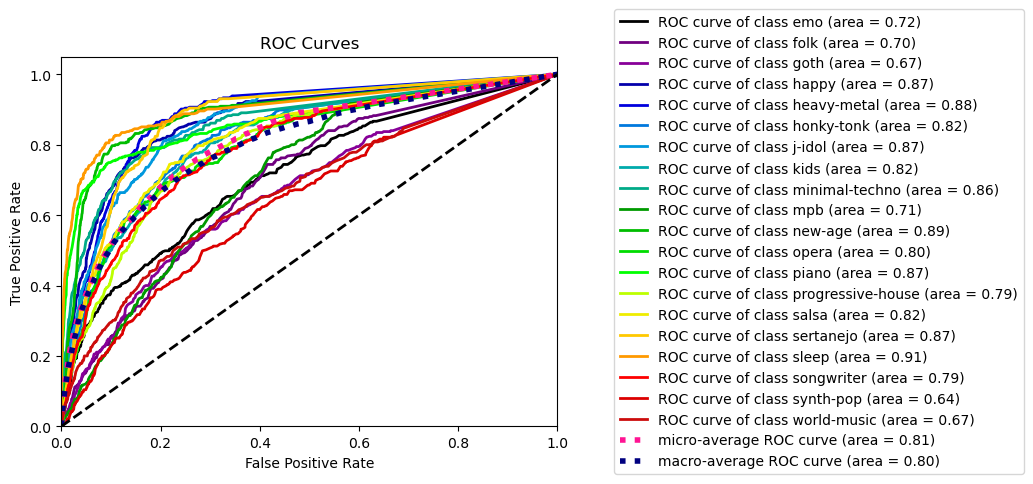

TOP 5 F1-SCORE:
sleep: 0.5887323943661972
piano: 0.5229357798165137
new-age: 0.45905707196029777
minimal-techno: 0.4060475161987041
happy: 0.3757292882147025


FLOP 5 F1-SCORE:
synth-pop: 0.08077544426494346
mpb: 0.09090909090909091
folk: 0.09230769230769231
goth: 0.11224489795918367
world-music: 0.13029315960912052


In [23]:
# decision tree selected model
model = DecisionTreeClassifier(criterion='entropy', max_depth=10, min_samples_leaf=30,
                       min_samples_split=75, random_state=8)
y_pred = decode_y(cross_val_predict(model, X_train_summary_scaled, y_train_raw, cv=10), enc_dict)
y_pred_proba = cross_val_predict(model, X_train_summary_scaled, y_train_raw, cv=10, method='predict_proba')

print(classification_report(decode_y(y_train_raw, enc_dict), y_pred))
plot_roc(decode_y(y_train_raw, enc_dict), y_pred_proba)
plt.legend(loc='center left',prop={'size': 10}, bbox_to_anchor=(1.1, 0.5))
plt.show()

top_flop_f1(decode_y(y_train_raw, enc_dict), y_pred)

In [49]:
# feature importance
model = DecisionTreeClassifier(criterion='entropy', max_depth=10, min_samples_leaf=30,
                       min_samples_split=75, random_state=8)
model.fit(X_train_summary_scaled, y_train_raw)

importances = model.feature_importances_
indices = list(reversed(np.argsort(importances)))

features = np.array(X_train_summary.columns)
features[indices[:5]]


array(['mad', '0.9', 'max', 'skew', '0.25'], dtype=object)

### Test

KNN

In [53]:
# knn
clf = KNeighborsClassifier(n_neighbors=100,metric='cosine', n_jobs=-1, weights='distance')
clf.fit(X_train_summary_scaled, y_train_raw)
y_pred = clf.predict(X_test_summary_scaled)
print(classification_report(decode_y(y_test_raw, enc_dict), decode_y(y_pred, enc_dict)))

                   precision    recall  f1-score   support

              emo       0.31      0.26      0.28       125
             folk       0.15      0.06      0.09       125
             goth       0.10      0.03      0.05       125
            happy       0.38      0.50      0.43       125
      heavy-metal       0.33      0.46      0.38       125
       honky-tonk       0.33      0.54      0.41       125
           j-idol       0.34      0.39      0.36       125
             kids       0.39      0.31      0.35       125
   minimal-techno       0.51      0.52      0.51       125
              mpb       0.10      0.05      0.06       125
          new-age       0.47      0.54      0.50       125
            opera       0.36      0.26      0.30       125
            piano       0.60      0.50      0.55       125
progressive-house       0.33      0.13      0.18       125
            salsa       0.28      0.60      0.38       125
        sertanejo       0.28      0.62      0.38       

In [54]:
clf = DecisionTreeClassifier(criterion='entropy', max_depth=10, min_samples_leaf=30,
                       min_samples_split=75, random_state=8)
clf.fit(X_train_summary_scaled, y_train_raw)
y_pred = clf.predict(X_test_summary_scaled)
print(classification_report(decode_y(y_test_raw, enc_dict), decode_y(y_pred, enc_dict)))

                   precision    recall  f1-score   support

              emo       0.19      0.18      0.18       125
             folk       0.11      0.07      0.09       125
             goth       0.05      0.01      0.01       125
            happy       0.31      0.42      0.36       125
      heavy-metal       0.25      0.37      0.30       125
       honky-tonk       0.26      0.34      0.30       125
           j-idol       0.25      0.28      0.27       125
             kids       0.38      0.30      0.34       125
   minimal-techno       0.38      0.55      0.45       125
              mpb       0.12      0.02      0.03       125
          new-age       0.48      0.48      0.48       125
            opera       0.31      0.30      0.30       125
            piano       0.58      0.48      0.52       125
progressive-house       0.26      0.22      0.24       125
            salsa       0.21      0.37      0.27       125
        sertanejo       0.26      0.55      0.35       